# Install detectron2

In [2]:
# !pip install pyyaml==5.1

# import torch
# TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
# CUDA_VERSION = torch.__version__.split("+")[-1]
# print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
# # Install detectron2 that matches the above pytorch version
# # See https://detectron2.readthedocs.io/tutorials/install.html for instructions
# !pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/$CUDA_VERSION/torch$TORCH_VERSION/index.html
# # If there is not yet a detectron2 release that matches the given torch + CUDA version, you need to install a different pytorch.

# # exit(0)  # After installation, you may need to "restart runtime" in Colab. This line can also restart runtime

In [3]:
import xml.etree.ElementTree as ET
import os
from tqdm import tqdm
import shutil
def modify_xml_jpg_file(data_dir, out_dir):
    jpg_path = list()
    xml_path = list()
    file_names = set()
    
    for root, dirs, files in os.walk(data_dir):
        for file in files:
            if file.endswith(".jpg"):
                if 'checkpoint' in file:
                    pass
                else:
                    file_path = os.path.join(root, file)
                    file_names.add(os.path.splitext(file_path.split(os.sep)[-1])[0])
                    jpg_path.append(file_path)
    
    for root, dirs, files in os.walk(data_dir):
        for file in files:
            if file.endswith(".xml"):
                if 'checkpoint' in file:
                    pass
                else:
                    file_path = os.path.join(root, file)
                    file_names.add(os.path.splitext(file_path.split(os.sep)[-1])[0])
                    xml_path.append(file_path)
    
    file_names = sorted(list(file_names))
    name_map = dict((n, i) for i, n in enumerate(file_names))
    
    for xml_file in tqdm(xml_path):
        xmlTree = ET.parse(xml_file)
        xml_name = os.path.splitext(xml_file.split(os.sep)[-1])[0]
        int_name = name_map[xml_name]
        rootElement = xmlTree.getroot()
        rootElement.findall("path")[0].text = f'{int_name}.jpg'
        rootElement.findall("filename")[0].text = f'{int_name}.jpg'

        sub_path = os.path.join(*xml_file.split(os.sep)[1:-1])
        write_dir = os.path.join(out_dir, sub_path)
        if os.path.exists(write_dir):
            pass
        else:
            os.makedirs(write_dir)

        write_path = os.path.join(write_dir, str(int_name)+'.xml')
        xmlTree.write(write_path, encoding='UTF-8', xml_declaration=True)
            
    for jpg_file in tqdm(jpg_path):
        jpg_name = os.path.splitext(jpg_file.split(os.sep)[-1])[0]
        int_name = name_map[jpg_name]

        sub_path = os.path.join(*jpg_file.split(os.sep)[1:-1])
        write_dir = os.path.join(out_dir, sub_path)
        if os.path.exists(write_dir):
            pass
        else:
            os.makedirs(write_dir)
        write_path = os.path.join(write_dir, str(int_name)+'.jpg')
        shutil.copy2(jpg_file, write_path)         

In [4]:
modify_xml_jpg_file('linmao-new', out_dir='linmao-new_processed')

100%|██████████| 8407/8407 [02:21<00:00, 59.29it/s] 


In [5]:
import os

dataset_directory = 'linmao-new_processed'

train_directory = './train'
validation_directory = './validation'

os.makedirs(train_directory, exist_ok=True)
os.makedirs(validation_directory, exist_ok=True)

In [6]:
import glob
import shutil
import random

train_ratio = 0.8

annotation_list = sorted(glob.glob(dataset_directory +'/Annotations'+ '/*.xml'))
image_list = sorted(glob.glob(dataset_directory +'/JPEGImages' + '/*.jpg'))

file_num = len(annotation_list)

index_list = list(range(file_num - 1))
random.shuffle(index_list)

for count, index in enumerate(tqdm(index_list)):
    if count < int(file_num * train_ratio):
        shutil.copy2(annotation_list[index], train_directory)
        shutil.copy2(image_list[index], train_directory)
    else:
        shutil.copy2(annotation_list[index], validation_directory)
        shutil.copy2(image_list[index], validation_directory)

100%|██████████| 8406/8406 [05:27<00:00, 25.66it/s] 


In [7]:
!python voc2coco.py train train/train_annotations.json
!python voc2coco.py validation validation/validation_annotations.json

Number of xml files: 6725
Success: train/train_annotations.json
Number of xml files: 1681
Success: validation/validation_annotations.json


In [8]:
!mkdir dataset
!mkdir dataset/images
!mkdir dataset/images/train2017
!mkdir dataset/images/val2017
!mkdir dataset/images/annotations

!cp -rf train/*.jpg dataset/images/train2017
!cp -rf validation/*.jpg dataset/images/val2017
!cp -rf train/train_annotations.json dataset/images/annotations
!cp -rf validation/validation_annotations.json dataset/images/annotations

In [31]:
from object_detect.convert_xml_label_to_txt import convert
import os
import shutil
xml_dir = 'validation'
out_dir = f'{xml_dir}_txt'

label_map = {'nl_0438': 0,
             'nl_0431': 1,
             'nl_0239': 2,
             'nl_0238': 3,
             'nl_0271': 4,
             'nl_0280': 5,
             'nl_0433': 6,
             'nl_0224': 7,
             'nl_0098': 8}

label_dict = convert(xml_dir, out_dir, label_map, True)

In [9]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

# Train on a custom dataset

In this section, we show how to train an existing detectron2 model on a custom dataset in a new format.

We use [the balloon segmentation dataset](https://github.com/matterport/Mask_RCNN/tree/master/samples/balloon)
which only has one class: balloon.
We'll train a balloon segmentation model from an existing model pre-trained on COCO dataset, available in detectron2's model zoo.

Note that COCO dataset does not have the "balloon" category. We'll be able to recognize this new class in a few minutes.

## Prepare the dataset

Register the balloon dataset to detectron2, following the [detectron2 custom dataset tutorial](https://detectron2.readthedocs.io/tutorials/datasets.html).
Here, the dataset is in its custom format, therefore we write a function to parse it and prepare it into detectron2's standard format. User should write such a function when using a dataset in custom format. See the tutorial for more details.


In [10]:
# if your dataset is in COCO format, this cell can be replaced by the following three lines:
from detectron2.data.datasets import register_coco_instances
register_coco_instances("linmao_train", {}, "dataset/images/annotations/train_annotations.json", "dataset/images/train2017")
register_coco_instances("linmao_val", {}, "dataset/images/annotations/validation_annotations.json", "dataset/images/val2017")


## Train!

Now, let's fine-tune a COCO-pretrained R50-FPN Mask R-CNN model on the balloon dataset. It takes ~2 minutes to train 300 iterations on a P100 GPU.


In [22]:
from detectron2.engine import DefaultTrainer

cfg = get_cfg()
#cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("linmao_train",)
cfg.DATASETS.TEST = ("linmao_val",)
cfg.DATALOADER.NUM_WORKERS = 1
#cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 4
cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR 0.00025 
cfg.SOLVER.MAX_ITER = 3000    # 300 iterations seems good enough for this toy dataset; you may need to train longer for a practical dataset
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 1280   # faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 9  # only has one class (ballon)

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=True)
trainer.train()

[01/30 01:27:01 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

In [11]:
# from detectron2.engine import DefaultTrainer

# cfg = get_cfg()
# cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
# cfg.DATASETS.TRAIN = ("my_dataset_train",)
# cfg.DATASETS.TEST = ()
# cfg.DATALOADER.NUM_WORKERS = 1
# cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
# cfg.SOLVER.IMS_PER_BATCH = 2
# cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
# cfg.SOLVER.MAX_ITER = 300    # 300 iterations seems good enough for this toy dataset; you will need to train longer for a practical dataset
# cfg.SOLVER.STEPS = []        # do not decay learning rate
# cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # faster, and good enough for this toy dataset (default: 512)
# cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # only has one class (ballon). (see https://detectron2.readthedocs.io/tutorials/datasets.html#update-the-config-for-new-datasets)
# # NOTE: this config means the number of classes, but a few popular unofficial tutorials incorrect uses num_classes+1 here.

# os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
# trainer = DefaultTrainer(cfg) 
# trainer.resume_or_load(resume=False)
# trainer.train()

In [23]:
# Inference should use the config with parameters that are used in training
# cfg now already contains everything we've set previously. We changed it a little bit for inference:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set a custom testing threshold
predictor = DefaultPredictor(cfg)

In [37]:
images_dir = 'dataset/images/val2017'
image_path = []

for root, dirs, files in os.walk(images_dir):
    for file in files:
        if file.endswith(".jpg"):
            if 'checkpoint' in file:
                pass
            else:
                file_path = os.path.join(root, file)
                image_path.append(file_path)

In [70]:
from tqdm import tqdm

out_put_dir = 'rcnn_pred'
os.makedirs(out_put_dir, exist_ok=True)

for img_pth in tqdm(image_path):
    name = os.path.splitext(img_pth.split(os.sep)[-1])[0]
    save_p = os.path.join(out_put_dir, f'{name}.txt')
    im = cv2.imread(img_pth)
    hight, width = im.shape[:2]
    
    outputs = predictor(im)
    output_data = outputs['instances'].to("cpu")
    
    boxes = [i.tolist() for i in list(output_data.pred_boxes)]
    scores = [i.tolist() for i in list(output_data.scores)]
    classes = output_data.pred_classes.tolist()

    
    result = []
    if output_data.has("pred_boxes"):
        for idx, box in enumerate(boxes):
            x1, y1, x2, y2 = box[0], box[1], box[2], box[3]
            conf = scores[idx]
            label = int(classes[idx])
            x = (x1 + x2)/2/width
            y = (y1 + y2)/2/hight
            w = (x2 - x1)/width
            h = (y2 - y1)/hight
            result.append(f"{label} {x} {y} {w} {h} {conf}")
        preds = "\n".join(result)  
        with open(save_p, "w+") as f:
            f.write(preds)

        


100%|██████████| 1681/1681 [04:53<00:00,  5.73it/s]


In [71]:
label_map = {0: 'nl_0438', 
             1: 'nl_0431', 
             2: 'nl_0239', 
             3: 'nl_0238', 
             4: 'nl_0271', 
             5: 'nl_0280', 
             6: 'nl_0433', 
             7: 'nl_0224', 
             8: 'nl_0098'}

In [72]:
from object_detect.metrics import label_metrics
pred_txt_dir = 'rcnn_pred' # runs/detect/combined_yolo_cls/labels
truth_txt_dir = 'validation_txt'
lm = label_metrics(pred_txt_dir, truth_txt_dir)
summary_df = lm.get_metrics(iou_thresholds=[0.5], interpolate_pr=True)

  0%|          | 0/9 [00:00<?, ?it/s]

processing IoU@0.5


100%|██████████| 9/9 [00:23<00:00,  2.66s/it]


In [73]:
summary_df.label = summary_df.label.replace(label_map)
summary_df

,label,P@0.5,R@0.5,F1@0.5,AP@0.5,P@All,R@All,F1@All,AP@All
0,nl_0438,0.976112,0.977945,0.977029,0.976217,0.976112,0.977945,0.977029,0.976217
1,nl_0431,0.994681,0.871795,0.933238,0.871558,0.994681,0.871795,0.933238,0.871558
2,nl_0239,0.930114,0.772152,0.851133,0.761111,0.930114,0.772152,0.851133,0.761111
3,nl_0238,0.957238,0.978315,0.967777,0.966882,0.957238,0.978315,0.967777,0.966882
4,nl_0271,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,nl_0280,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,nl_0433,1.000000,0.877698,0.938849,0.877698,1.000000,0.877698,0.938849,0.877698
7,nl_0224,0.891566,0.778947,0.835257,0.752795,0.891566,0.778947,0.835257,0.752795
8,nl_0098,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,All,0.638857,0.584095,0.611476,0.578473,0.638857,0.584095,0.611476,0.578473


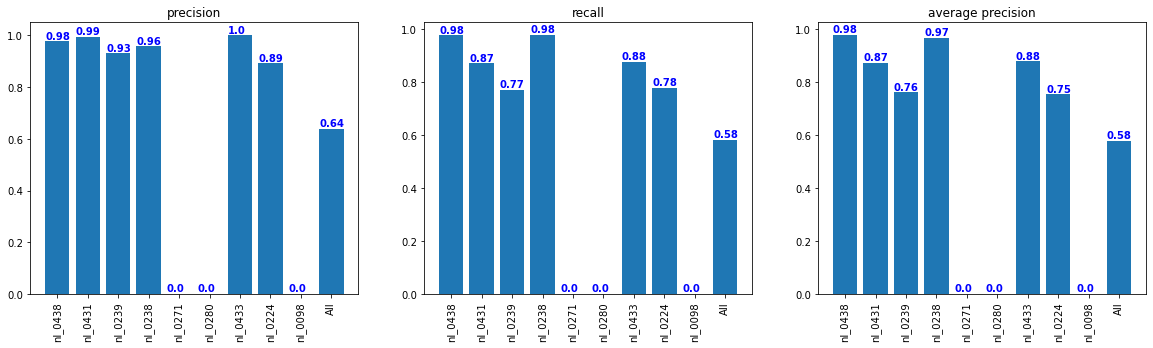

In [74]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 5))
plt.subplot(131)
x = [str(i) for i in summary_df['label']]
precisions = summary_df['P@0.5'].tolist()
plt.title('precision')
plt.bar(x, precisions)
plt.xticks(rotation=90)
for i, v in enumerate(x):
    plt.text(i-0.4, precisions[i]+0.01, str(round(precisions[i], 2)), color='blue', fontweight='bold')

plt.subplot(132)
recalls = summary_df['R@0.5'].tolist()
plt.title('recall')
plt.bar(x, recalls)
plt.xticks(rotation=90)
for i, v in enumerate(x):
    plt.text(i-0.4, recalls[i]+0.01, str(round(recalls[i], 2)), color='blue', fontweight='bold')

plt.subplot(133)
aps = summary_df['AP@0.5'].tolist()
plt.title('average precision')
plt.bar(x, aps)
plt.xticks(rotation=90)
for i, v in enumerate(x):
    plt.text(i-0.4, aps[i]+0.01, str(round(aps[i], 2)), color='blue', fontweight='bold')